In [1]:
import pandas as pd
import os

In [2]:
topic = 'feminism'
scheme = 'EIII_v2'

path = os.getcwd()
clean_path = f'{path}/clean'
NN_path = f'{path}/NN/{topic}/{scheme}'

train_file = f'{path}/train/labeled_{topic}_train.csv'
test_file = f'{path}/test/labeled_{topic}_test.csv'

os.makedirs(NN_path, exist_ok=True)
os.makedirs(f'{clean_path}/train', exist_ok=True)
os.makedirs(f'{clean_path}/test', exist_ok=True)

NN_path

'/media/rinnely/Archer/ENES/Stance/Clasificador/NN/feminism/EIII_v2'

In [3]:
train = pd.read_csv(train_file)

In [4]:
train.head()

,id,Tweet,Label_EI,Stance_EI,Label_EII,Stance_EII
0,1343345719374188544,even though this person is basically using fem...,0,Uknown,1,Favor
1,1343345503434649600,"This... Opinion | During the Coronavirus, Femi...",0,Uknown,1,Favor
2,1343345499278086144,So I am a mixed Black person and that has evol...,0,Uknown,1,Favor
3,1343345498862858240,"Bidisha, in Chapter 6 of The Fifty Shades of F...",0,Uknown,0,Uknown
4,1343345262228631554,@hamelitee because of feminism. ;-) balls are ...,0,Uknown,1,Favor


In [ ]:
train = train[[f'Label_{scheme}', 'Tweet']]
train.columns = ['Label', 'Tweet']

In [ ]:
train.head()

In [ ]:
train.Label.unique()

In [ ]:
train = train.query('Label != 0')
train.Label.unique()

In [ ]:
train.groupby('Label').count()

In [ ]:
test = pd.read_csv(test_file)
test.head()

In [ ]:
test = test[['Stance', 'Tweet']]
test.Stance.unique()

In [ ]:
test['Stance']= test.Stance.replace({'FAVOR':1, 'AGAINST':-1, 'C':0})
test = test.query('Stance != 0')
test.Stance.unique()

In [ ]:
test.columns = ['Label', 'Tweet']
test.groupby('Label').count()

In [ ]:
train.shape, test.shape

# clean data

In [42]:
import sys
sys.path.insert(0, '/media/rinnely/Archer/ENES/Stance')
import cleandata as cd

In [ ]:
train = cd.cleanData(train.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')
test = cd.cleanData(test.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')

In [ ]:
train = train.dropna(axis=0)

# save data

In [ ]:
train.to_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv', index=False)
test.to_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv', index=False)

# read data

In [3]:
train = pd.read_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv')
test = pd.read_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv')

<AxesSubplot:ylabel='Label'>

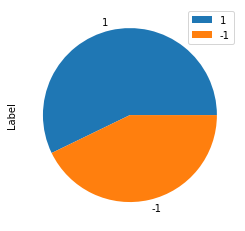

In [6]:
train['Label'].value_counts().plot.pie(legend=True)

In [ ]:
test['Label'].value_counts().plot.pie(legend=True)

In [ ]:
train['Label'].value_counts().plot.bar(legend=True)

In [ ]:
test['Label'].value_counts().plot.bar(legend=True)

In [ ]:
train

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train = train.dropna(axis=0)

In [ ]:
train.info()

# Training

In [4]:
from fastai.text import *

In [5]:
data_lm = (TextList.from_df(train, NN_path, cols='Tweet')
          .split_by_rand_pct(0.2)
          .label_for_lm() # this does the tokenization and numericalization
          .databunch())

/home/rinnely/anaconda3/lib/python3.8/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
data_lm.show_batch()

In [6]:
data_clas = TextClasDataBunch.from_df(NN_path, train_df=train, 
                                      valid_df=test, 
                                      vocab=data_lm.vocab, 
                                      text_cols = 'Tweet', 
                                      label_cols = 'Label',
                                      bs=32)

/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data_clas.show_batch()

In [ ]:
f'data_clas_{topic}_{scheme}'

In [ ]:
data_lm.save(f'data_lm_{topic}_{scheme}')
data_clas.save(f'data_clas_{topic}_{scheme}')

In [ ]:
data_lm.train_ds.vocab.itos[:10], len(data_lm.train_ds.vocab.itos)

In [7]:
#learn = ftxt.language_model_learner(data_lm, arch=ftxt.AWD_LSTM, drop_mult=.2)
learn_lm = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 6.31E-02


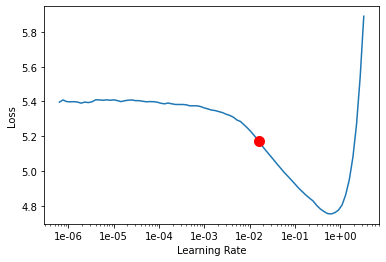

In [8]:
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [9]:
learn_lm.fit_one_cycle(5,2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.865867,3.889424,0.279554,00:05
1,4.226590,3.469309,0.326696,00:05
2,3.831557,3.396596,0.335402,00:05
3,3.552859,3.371673,0.338884,00:05
4,3.364516,3.366304,0.339330,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03
Min loss divided by 10: 1.32E-03


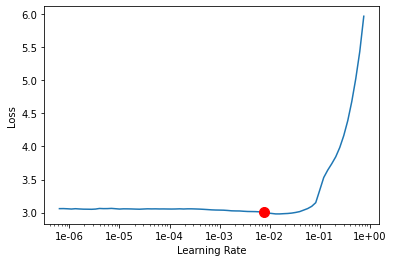

In [10]:
learn_lm.unfreeze()
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [11]:
learn_lm.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,3.037670,3.327705,0.345223,00:08
1,2.961541,3.303527,0.350045,00:08
2,2.890422,3.295554,0.350268,00:08


In [12]:
learn_lm.save_encoder(f'{topic}_ml_encoder_v1')

In [13]:
learn_lm.load_encoder(f'{topic}_ml_encoder_v1');

In [14]:
learn_lm.save(f'{topic}_model_v1')

In [15]:
learn_lm.load(f'{topic}_model_v1');

In [16]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [17]:
from sklearn.metrics import f1_score

@np_func #converts torch tesnsor as numpy array
def f1_macro(inp, targ): return f1_score(targ, np.argmax(inp, axis=1), average='macro')

In [18]:
learn.load_encoder(f'{topic}_ml_encoder_v1')
learn.metrics=[f1_macro]
learn.freeze()

In [19]:
learn.save('learner-1stage')

In [20]:
learn.load('learner-1stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 2.09E-02


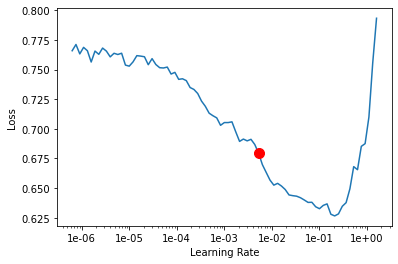

In [21]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [22]:
learn.fit_one_cycle(5,5e-3,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.538688,0.629407,0.542583,00:06
1,0.516953,0.621546,0.603703,00:05
2,0.504588,0.653285,0.563993,00:06
3,0.477658,0.607569,0.587301,00:06
4,0.447496,0.610279,0.595945,00:06


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [23]:
learn.save('learner-2stage')

In [24]:
learn.load('learner-2stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.91E-07


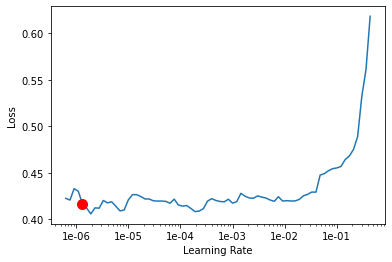

In [25]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [26]:
learn.fit_one_cycle(3, 1e-6,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.444235,0.613594,0.603767,00:05
1,0.462476,0.607746,0.590881,00:05
2,0.455690,0.625229,0.602758,00:05


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [27]:
learn.save('learner-3stage')

In [28]:
learn.load('learner-3stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


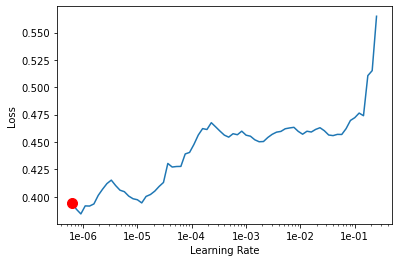

In [29]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [30]:
learn.fit_one_cycle(5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.459078,0.613718,0.554093,00:06
1,0.460304,0.693543,0.611656,00:06
2,0.459010,0.615883,0.597994,00:06
3,0.449317,0.631347,0.587970,00:06
4,0.449513,0.620000,0.584628,00:05


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 2.51E-06


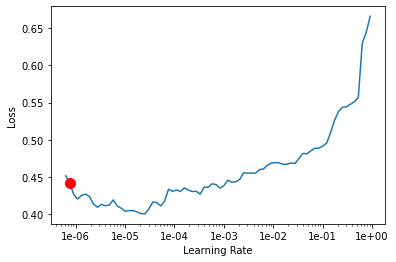

In [31]:
learn.freeze_to(-2)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [32]:
learn.fit_one_cycle(3,7e-7,moms=(0.8, 0.7));

epoch,train_loss,valid_loss,f1_macro,time
0,0.423730,0.632571,0.583746,00:06
1,0.440588,0.624596,0.592075,00:07
2,0.455262,0.621922,0.587349,00:07


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [33]:
learn.save('learner-stage-freeze-2')

In [34]:
learn.save('learner-stage-freeze-2')

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-06


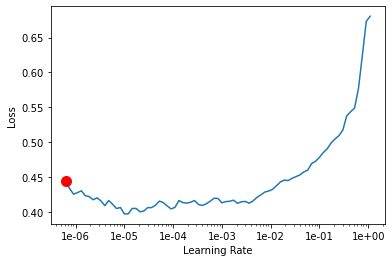

In [35]:
learn.freeze_to(-3)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [36]:
learn.fit_one_cycle(3, 6e-7, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.431204,0.627922,0.589259,00:11
1,0.440356,0.618966,0.579009,00:11
2,0.419359,0.620272,0.570181,00:11


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [37]:
learn.save('learner-stage-freeze-3')

In [38]:
learn.load('learner-stage-freeze-3');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


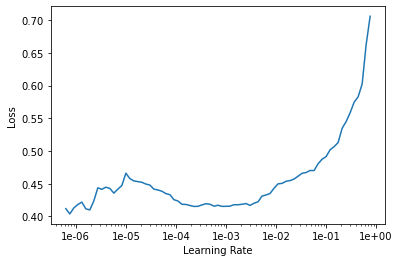

In [39]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [40]:
learn.fit_one_cycle(3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.411587,0.630759,0.602523,00:15
1,0.370951,0.681268,0.619850,00:15
2,0.265407,0.716607,0.628809,00:15


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [43]:
data = pd.read_csv(train_file)
data.head()
data['NNAgainst'] = ''
data['NNFavor'] = ''
data.head()
data = cd.cleanData(data.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')
data.head()

,id,Tweet,Label_EI,Stance_EI,Label_EII,Stance_EII,NNAgainst,NNFavor
0,1343345719374188544,even though this person is basically using fem...,0,Uknown,1,Favor,,
1,1343345503434649600,"This... Opinion | During the Coronavirus, Femi...",0,Uknown,1,Favor,,
2,1343345499278086144,So I am a mixed Black person and that has evol...,0,Uknown,1,Favor,,
3,1343345498862858240,"Bidisha, in Chapter 6 of The Fifty Shades of F...",0,Uknown,0,Uknown,,
4,1343345262228631554,USER because of feminism. ;-) balls are a miso...,0,Uknown,1,Favor,,


In [44]:
from tqdm.notebook import tqdm, trange
import time 
for i in trange(data.shape[0]):
    #time.sleep(0.01)
    data.loc[i,'Tweet']
    result = learn.predict(data.loc[i,'Tweet'])
    r = result[2].numpy()
    data.loc[i,'NNAgainst'] = r[0]
    data.loc[i,'NNFavor'] = r[1]

  0%|          | 0/3574 [00:00<?, ?it/s]

In [45]:
data['NNPred'] = data[['NNFavor','NNAgainst']].apply(lambda x : 1 if x[0] >= 0.70 else( -1 if x[1] >= 0.70 else 0 ),axis=1)

In [46]:
data

,id,Tweet,Label_EI,Stance_EI,Label_EII,Stance_EII,NNAgainst,NNFavor,NNPred
0,1343345719374188544,even though this person is basically using fem...,0,Uknown,1,Favor,0.271997,0.728003,1
1,1343345503434649600,"This... Opinion | During the Coronavirus, Femi...",0,Uknown,1,Favor,0.871849,0.128151,-1
2,1343345499278086144,So I am a mixed Black person and that has evol...,0,Uknown,1,Favor,0.768,0.232,-1
3,1343345498862858240,"Bidisha, in Chapter 6 of The Fifty Shades of F...",0,Uknown,0,Uknown,0.600495,0.399505,0
4,1343345262228631554,USER because of feminism. ;-) balls are a miso...,0,Uknown,1,Favor,0.969204,0.030796,-1
...,...,...,...,...,...,...,...,...,...
3569,1265362578307457025,"""Women against Women"" What does femisim say ab...",1,Favor,0,Uknown,0.17848,0.821519,1
3570,1265287105690787845,This tweet and its replies could change the world,1,Favor,1,Favor,0.110967,0.889033,1
3571,1265224115042103299,What is the problem with political philosophy ...,1,Favor,1,Favor,0.259003,0.740997,1
3572,1265178143494746114,May the peace that comes with this season neve...,1,Favor,1,Favor,0.002532,0.997468,1


In [47]:
data.to_csv('/media/rinnely/Archer/ENES/Stance/Clasificador/train/labeled_feminism_NNtrain.csv', index=False)

In [48]:
learn.save('learner-stage-unfreeze-62')

In [49]:
learn.load('learner-stage-unfreeze-62');

In [51]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = TextClassificationInterpretation(learn, preds, y, losses)

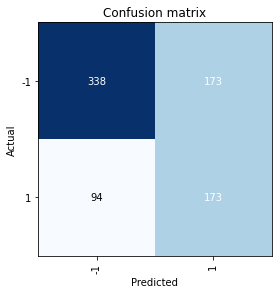

In [52]:
interp.plot_confusion_matrix()

In [ ]:
preds

In [53]:
learn.save('learner-final')